# Instacart Market Analysis

    
<br>
Utilisez des données anonymisées sur les commandes des clients au fil du temps pour prédire quels produits précédemment achetés seront dans la prochaine commande d’un utilisateur.
***


In [3]:
# Chargement de librairie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import lightgbm as lgb

## Importez les Datas

In [5]:
# import data
orders = pd.read_csv("C:/Users/aaron/OneDrive/Documents/AARON ECOLE/ESG FINANCE/MACHINE_LEARNING/TP/TP2/kaggle_instacart-master/Instacart-Market-Basket-Analysis/Data_market_analysis/orders.csv")

order_prior = pd.read_csv("C:/Users/aaron/OneDrive/Documents/AARON ECOLE/ESG FINANCE/MACHINE_LEARNING/TP/TP2/kaggle_instacart-master/Instacart-Market-Basket-Analysis/Data_market_analysis/order_products__prior.csv")

order_train = pd.read_csv("C:/Users/aaron/OneDrive/Documents/AARON ECOLE/ESG FINANCE/MACHINE_LEARNING/TP/TP2/kaggle_instacart-master/Instacart-Market-Basket-Analysis/Data_market_analysis/order_products__train.csv")

aisles = pd.read_csv("C:/Users/aaron/OneDrive/Documents/AARON ECOLE/ESG FINANCE/MACHINE_LEARNING/TP/TP2/kaggle_instacart-master/Instacart-Market-Basket-Analysis/Data_market_analysis/aisles.csv")

departments = pd.read_csv("C:/Users/aaron/OneDrive/Documents/AARON ECOLE/ESG FINANCE/MACHINE_LEARNING/TP/TP2/kaggle_instacart-master/Instacart-Market-Basket-Analysis/Data_market_analysis/departments.csv"
)
products = pd.read_csv("C:/Users/aaron/OneDrive/Documents/AARON ECOLE/ESG FINANCE/MACHINE_LEARNING/TP/TP2/kaggle_instacart-master/Instacart-Market-Basket-Analysis/Data_market_analysis/products.csv")

## Exploration de données

In [7]:
# Consulter  des données
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [9]:
order_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [10]:
aisles.head(2)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses


In [11]:
departments.head(2)

,department_id,department
0,1,frozen
1,2,other


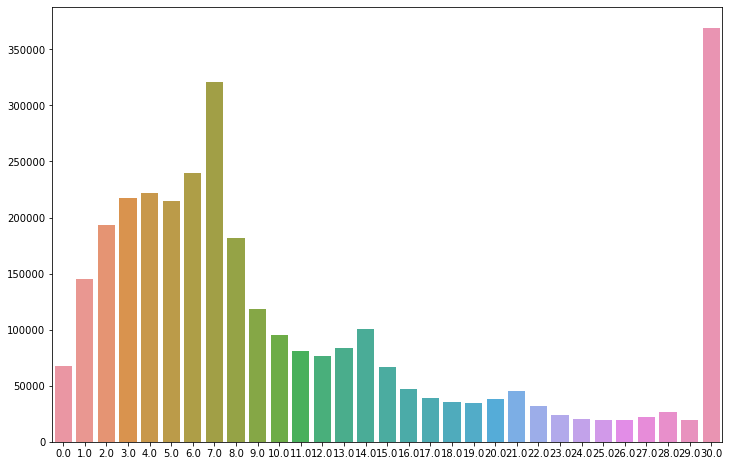

In [12]:
# Combien de temps l'article est-il recommandé
reorder_period = orders.days_since_prior_order.value_counts()
plt.figure(figsize=(12,8))
sns.barplot(reorder_period.index, reorder_period.values)
plt.show()

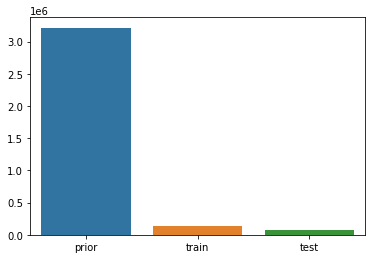

In [13]:
# train test prior proportion
datatype = orders.eval_set.value_counts()
plt.figure(figsize=(6,4))
sns.barplot(datatype.index, datatype.values)
plt.show()

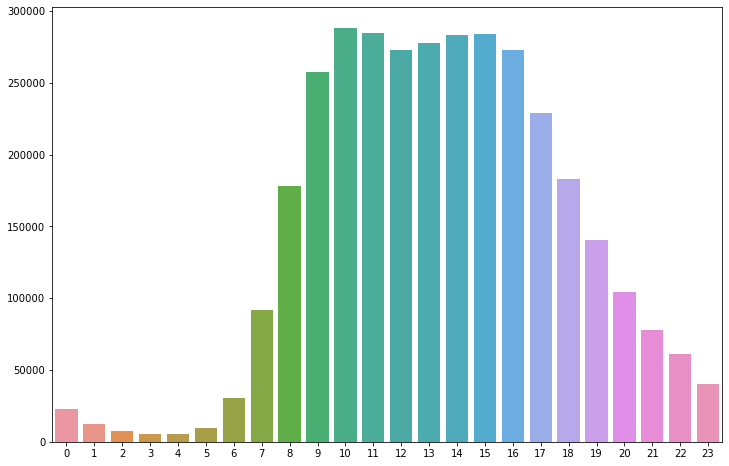

In [14]:
# Heure de commande dans la journée
hour = orders.order_hour_of_day.value_counts()
plt.figure(figsize=(12,8))
sns.barplot(hour.index, hour.values)
plt.show()

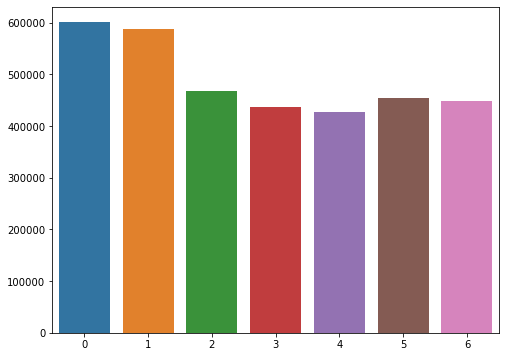

In [15]:
# Jour de commande dans la semaine
dow = orders.order_dow.value_counts()
plt.figure(figsize=(8,6))
sns.barplot(dow.index, dow.values)
plt.show()

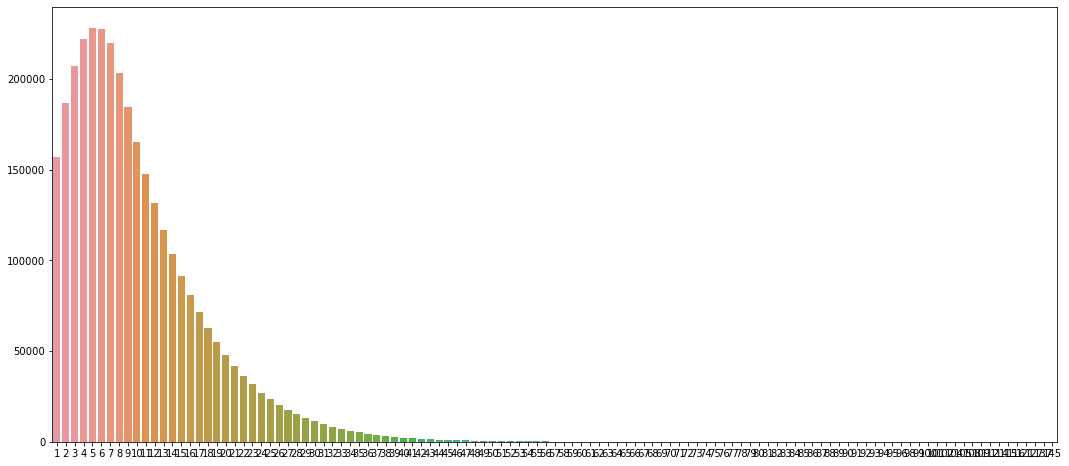

In [16]:
# Vérifier le nombre d’articles commandés dans une seule commande
item_amount = order_prior.groupby("order_id")['add_to_cart_order'].max().reset_index()
count = item_amount.add_to_cart_order.value_counts()
fig = plt.figure(figsize=(18,8))
sns.barplot(count.index, count.values)

## Benchmark: 
### Prédire en répétant les articles achetés à partir de la commande précédente

In [18]:
previous_order = pd.concat([order_train, order_prior]).reset_index()

In [19]:
previous_order.drop("index",1)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
33819101,3421083,39678,6,1
33819102,3421083,11352,7,0
33819103,3421083,4600,8,0
33819104,3421083,24852,9,1


In [20]:
orders_new = pd.merge(left = orders,right = previous_order, on="order_id", how="left")
orders_new.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,index,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,24076664.0,196.0,1.0,0.0
1,2539329,1,prior,1,2,8,NaN,24076665.0,14084.0,2.0,0.0
2,2539329,1,prior,1,2,8,NaN,24076666.0,12427.0,3.0,0.0
3,2539329,1,prior,1,2,8,NaN,24076667.0,26088.0,4.0,0.0
4,2539329,1,prior,1,2,8,NaN,24076668.0,26405.0,5.0,0.0


In [21]:
test_orders = orders[orders.eval_set == 'test']
test_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [22]:
test_history = orders_new[(orders_new.user_id.isin(test_orders.user_id))]
last_orders = test_history.groupby('user_id')['order_number'].max()
last_orders.head()

user_id
3     13
4      6
6      4
11     8
12     6
Name: order_number, dtype: int64

In [17]:
test_history.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,index,product_id,add_to_cart_order,reordered
296,1374495,3,prior,1,1,14,NaN,13022418.0,9387.0,1.0,0.0
297,1374495,3,prior,1,1,14,NaN,13022419.0,17668.0,2.0,0.0
298,1374495,3,prior,1,1,14,NaN,13022420.0,15143.0,3.0,0.0
299,1374495,3,prior,1,1,14,NaN,13022421.0,16797.0,4.0,0.0
300,1374495,3,prior,1,1,14,NaN,13022422.0,39190.0,5.0,0.0


In [23]:
def get_last_orders():
    t = pd.merge(
            left=pd.merge(
                    left=last_orders.reset_index(),
                    right=test_history,
                    how='inner',
                    on=['user_id', 'order_number']
                )[['user_id', 'product_id']],
            right=test_orders[['user_id', 'order_id']],
            how='left',
            on='user_id'
        ).groupby('order_id')['product_id'].apply(lambda x: ' '.join([str(e) for e in set(x)])).reset_index()
    t.columns = ['order_id', 'products']
    return t

# save submission
get_last_orders().to_csv('last_order.csv', encoding='utf-8', index=False)

## LightGBM model

In [24]:
#Taux de réapprovisionnement du produit
prods = pd.DataFrame()
prods['orders'] = order_prior.groupby(order_prior.product_id).size().astype(np.int32)
prods['reorders'] = order_prior['reordered'].groupby(order_prior.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)
del prods

In [25]:
#ajouter les informations de commande 
orders.set_index('order_id', inplace=True, drop=False)
priors = order_prior.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

In [27]:
#computer user features
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
del usr
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print (users.head(2))

total_items                                       all_products  \
user_id                                                                   
1                 59  {17122, 196, 26405, 46149, 14084, 13032, 26088...   
2                195  {45066, 2573, 18961, 23, 32792, 1559, 22559, 1...   

         total_distinct_items  average_days_between_orders  nb_orders  \
user_id                                                                 
1                          18                    19.000000         11   
2                         102                    16.285715         15   

         average_basket  
user_id                  
1              5.363636  
2             13.000000  


In [28]:
#compute user x product id
priors['user_product'] = priors.product_id + priors.user_id * 100000

In [29]:
#Make user x product features
d= dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)

userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('user X product len:', len(userXproduct))

del priors

user X product len: 13307953


In [30]:
# train/test data split
test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

order_train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

In [31]:
# Build candidate list of product to reorder
def features(selected_orders, labels_given=False):
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%10000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in order_train.index for product in user_products]
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    #user related features
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    #order related features
    # df['dow'] = df.order_id.map(orders.order_dow)
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    #product related features
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    #user_X_product related features
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    

    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    print(df.dtypes)
    print(df.memory_usage())
    return (df, labels)

In [32]:
# create train data
df_train, labels = features(train_orders, labels_given=True)

f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last']

order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order row 80000
order row 90000
order row 100000
order row 110000
order row 120000
order row 130000
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                     int64
days_since_prior_order              float64
days_since_ratio                    float64
aisle_id                              int64
department_id                         int64
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int16
UP_orders_ratio                     float32
UP_average_pos_in_cart              floa

In [33]:
# format for lgb
d_train = lgb.Dataset(df_train[f_to_use],
                      label=labels,
                      categorical_feature=['aisle_id', 'department_id'])  
df_train

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 10
}
ROUNDS = 1000

In [34]:
# train lgb
bst = lgb.train(params, d_train, ROUNDS)
# create test data
df_test, _ = features(test_orders)
# predit test label
preds = bst.predict(df_test[f_to_use])
df_test['pred'] = preds

order row 10000
order row 20000
order row 30000
order row 40000
order row 50000
order row 60000
order row 70000
order_id                              int32
product_id                            int32
user_total_orders                     int16
user_total_items                      int16
total_distinct_items                  int16
user_average_days_between_orders    float32
user_average_basket                 float32
order_hour_of_day                     int64
days_since_prior_order              float64
days_since_ratio                    float64
aisle_id                              int64
department_id                         int64
product_orders                        int32
product_reorders                    float32
product_reorder_rate                float32
UP_orders                             int16
UP_orders_ratio                     float32
UP_average_pos_in_cart              float32
UP_reorder_rate                     float32
UP_orders_since_last                  int64
UP_delta

In [35]:
TRESHOLD = 0.25

d = dict()
for row in df_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

In [36]:
df_test.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,...,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,pred
0,2774568,17668,13,88,33,12.0,6.769231,15,11.0,0.916667,...,2110,1220.0,0.578199,5,0.384615,3.60,0.384615,2,3,0.401320
1,2774568,44683,13,88,33,12.0,6.769231,15,11.0,0.916667,...,22275,11981.0,0.537868,2,0.153846,9.50,0.153846,7,1,0.064542
2,2774568,48523,13,88,33,12.0,6.769231,15,11.0,0.916667,...,5129,2376.0,0.463248,2,0.153846,6.50,0.153846,4,1,0.092891
3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,0.916667,...,241921,186884.0,0.772500,8,0.615385,4.25,0.615385,1,0,0.630501
4,2774568,14992,13,88,33,12.0,6.769231,15,11.0,0.916667,...,29069,16942.0,0.582820,2,0.153846,7.00,0.153846,6,0,0.078955


In [37]:
# submission
sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('C:/Users/aaron/OneDrive/Documents/AARON ECOLE/ESG FINANCE/MACHINE_LEARNING/TP/TP2/kaggle_instacart-master/Instacart-Market-Basket-Analysis/Data_market_analysis/submission_lgb_Aaron.csv', index=False)